# Лекция 1
+ Rate streaming
+ File streaming
+ Kafka streaming

In [1]:
# !pip install pyspark[sql] findspark --user

import sys

import findspark
findspark.init()
findspark.find()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


spark = SparkSession.builder \
    .appName("Spark Streaming") \
    .config("spark.driver.extraJavaOptions", "-Dcom.sun.net.ssl.checkRevocation=false") \
    .config("spark.executor.extraJavaOptions", "-Dcom.sun.net.ssl.checkRevocation=false") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:3.2.1") \
    .config("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "512mb") \
    .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Ivy Default Cache set to: /home/jupyter-admin/.ivy2/cache
The jars for the packages stored in: /home/jupyter-admin/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5a3bacfc-17dc-4b28-9172-1ed88a7b0e7c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;3.2.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10

In [2]:
spark

# Structured Streaming
Есть ещё и Spark Streaming, не стоит их путать. Spark Streaming для rdd, Structured Streaming - свежая улучшенная версия.
https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html  
Краткая выжимка, что нужно знать:
1. Spark Structured Streaming позволяет работать с потоковыми данными, при этом можно использовать все преимущества Spark SQL;
2. Микро-пакетный подход, почти real-time (до \~100 ms), но есть Continuous Processing (\~1 ms);
2. В первую очередь для считывания записи из/в директории/kafka;
3. sink.start() - для запуска, sink.stop() - для остановки.

## Rate streaming (тестовый стрим)

Самый простой способ создать стрим - использовать `rate` источник. Созданный DF является streaming, о чем нам говорит метод создания `readStream` и атрибут `isStreaming`. `rate` хорошо подходит для тестирования приложений, когда нет возможности подключится к потоку реальных данных.  
RateStreamSource is a streaming source that generates consecutive numbers with timestamp that can be useful for testing and PoCs.

In [3]:
df = spark.range(10)
sdf = spark \
    .readStream \
    .format("rate") \
    .load() #.option("param", "value")\.option("param", "value") \.option("param", "value") \

print(f'Is streaming: df - \'{df.isStreaming}\', sdf - \'{sdf.isStreaming}\'')

Is streaming: df - 'False', sdf - 'True'


но sdf выглдядит как df

In [4]:
sdf = spark \
    .readStream \
    .format("rate") \
    .load()
sdf

DataFrame[timestamp: timestamp, value: bigint]

In [5]:
sdf.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- value: long (nullable = true)



In [6]:
sdf.explain(True)

== Parsed Logical Plan ==
StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.RateStreamProvider@a553a13, rate, org.apache.spark.sql.execution.streaming.sources.RateStreamTable@25fc77d8, org.apache.spark.sql.util.CaseInsensitiveStringMap@1f, [timestamp#6, value#7L]

== Analyzed Logical Plan ==
timestamp: timestamp, value: bigint
StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.RateStreamProvider@a553a13, rate, org.apache.spark.sql.execution.streaming.sources.RateStreamTable@25fc77d8, org.apache.spark.sql.util.CaseInsensitiveStringMap@1f, [timestamp#6, value#7L]

== Optimized Logical Plan ==
StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.RateStreamProvider@a553a13, rate, org.apache.spark.sql.execution.streaming.sources.RateStreamTable@25fc77d8, org.apache.spark.sql.util.CaseInsensitiveStringMap@1f, [timestamp#6, value#7L]

== Physical Plan ==
StreamingRelation rate, [timestamp#6, value#7L]



Но в отличии от обычных `df`, у `sdf` нет таких методов, как `show`, `collect`, `take`. Поэтому для того, чтобы посмотреть их содержимое, мы должны использовать `console` синк и создать `StreamingQuery`. Процессинг начинается только после вызова метода `start`.  
1) `trigger` позволяет настроить, как часто стрим будет читать новые данные и обрабатывать их  
2) `numRows` для консоли ограничивает кол-во строк для вывода  
3) `truncate` для консоли ограничивает вывод строк

In [7]:
def create_console_sink(sdf):
    return sdf \
            .writeStream \
            .format("console") \
            .trigger(processingTime="10 seconds") \
            .option("truncate", "false") \
            .option("numRows", "10")

In [8]:
sink = create_console_sink(sdf)
sink

In [9]:
sq = sink.start()
sq.isActive

2022-05-11 16:04:18,208 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-0a335def-5515-40aa-bbb3-a911442f08d4. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


True

-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+
|timestamp|value|
+---------+-----+
+---------+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+-----------------------+-----+
|timestamp              |value|
+-----------------------+-----+
|2022-05-11 16:04:18.392|0    |
|2022-05-11 16:04:19.392|1    |
+-----------------------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+-----------------------+-----+
|timestamp              |value|
+-----------------------+-----+
|2022-05-11 16:04:20.392|2    |
|2022-05-11 16:04:22.392|4    |
|2022-05-11 16:04:24.392|6    |
|2022-05-11 16:04:26.392|8    |
|2022-05-11 16:04:28.392|10   |
|2022-05-11 16:04:21.392|3    |
|2022-05-11 16:04:23.392|5    |
|2022-05-11 16:04:25.392|7    |
|2022-05-11 16:04:27.392|9    |
+-----------------------+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+-----------------------+-----+
|timestamp              |value|
+-----------------------+-----+
|20

In [10]:
sq.stop()

Чтобы остановить sdf, можно вызвать метод `stop` к `sdf`, либо получить список всех streming DF и остановить их:

In [11]:
def kill_all():
    streams = SparkSession.builder.getOrCreate().streams.active
    if streams:
        for stream in streams:
            desc = stream.lastProgress["sources"][0]["description"]
            stream.stop()
            print("Stopped {s}".format(s=desc))

In [12]:
# Можно запускать несколько стримов
sink1 = create_console_sink(sdf)
sq1 = sink1.start()

sink2 = create_console_sink(sdf)
sq2 = sink2.start()

sink3 = create_console_sink(sdf)
sq3 = sink3.start()

2022-05-11 16:04:45,005 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-d379fc22-54b0-4702-a9d7-d4e3956e692e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
2022-05-11 16:04:45,100 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-0180a22c-3fc5-4d66-b76a-58db01842f3b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
2022-05-11 16:04:45,166 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-ee014a5d-19ce-4874-ac47-302

-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+
|timestamp|value|
+---------+-----+
+---------+-----+

-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+
|timestamp|value|
+---------+-----+
+---------+-----+

-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+
|timestamp|value|
+---------+-----+
+---------+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+-----------------------+-----+
|timestamp              |value|
+-----------------------+-----+
|2022-05-11 16:04:45.095|0    |
|2022-05-11 16:04:47.095|2    |
|2022-05-11 16:04:46.095|1    |
|2022-05-11 16:04:48.095|3    |
+-----------------------+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+-----------------------+-----+
|timest

In [13]:
kill_all()

Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default
Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default
Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default


## Микробатчевая обработка и непрерывная
Тестовый поток протестирвоали. Попробуем писать в файл и считывать из файла

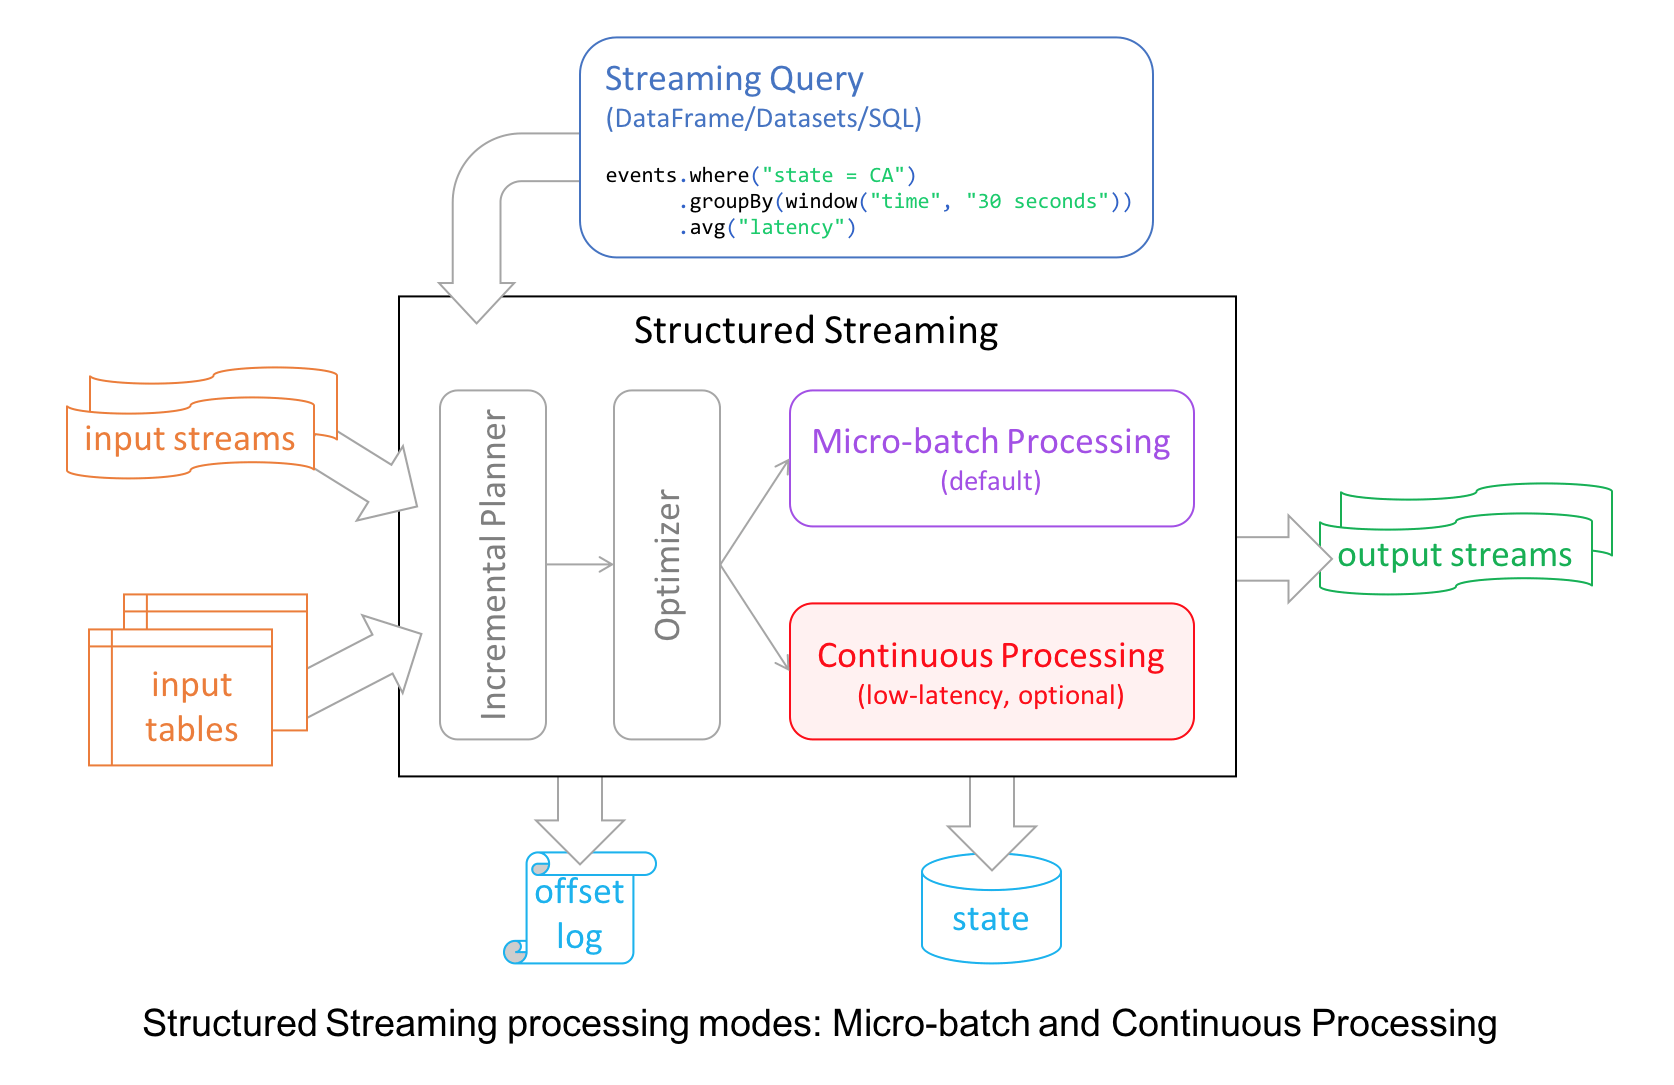

По умолчанию используется микробатчевая архитектура. Spark принимает данные из разных источников и объединяет их в небольшие пакеты. Новые пакеты создаются через регулярные интервалы времени. В начале каждого интервала времени создается новый пакет, и любые данные, поступившие в течение этого интервала, включаются в пакет. В конце интервала увеличение пакета прекращается.
Реализуется end-to-end exactly-once обработка - тот подход гарантирует, что мы обработаем сообщение только один раз.
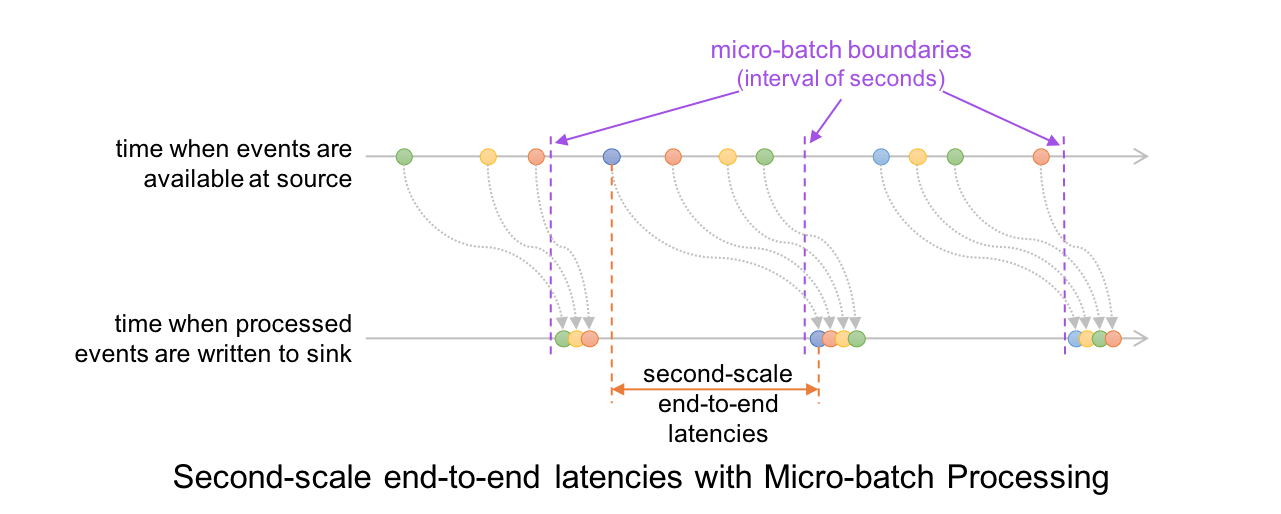

Подробнее так же можно почитать тут: https://databricks.com/blog/2018/03/20/low-latency-continuous-processing-mode-in-structured-streaming-in-apache-spark-2-3-0.html  
Далее будем рассматривать только микробатчевую архитектуру

Посмотрим как записывать данные в файл:

In [14]:
def create_parquet_sink(df, file_name):
    return df \
            .writeStream \
            .format("parquet") \
            .option("path", "/tmp/output/{f}".format(f=file_name)) \
            .option("checkpointLocation", "/tmp/chk/{f}".format(f=file_name)) \
            .trigger(processingTime="5 seconds")

In [17]:
sink = create_parquet_sink(sdf, 'data.parquet')
sink

In [18]:
import time

sq = sink.start()
time.sleep(10)
sq.stop()

rates = spark.read.parquet("/tmp/output/data.parquet")
print(f'Было записано {rates.count()} строк')

Было записано 1369981 строка


In [19]:
# Файлы пишутся в hdfs
!hdfs dfs -ls -h /tmp/output/data.parquet | wc -l

67


In [20]:
# Кажды батч - это новый файл в директории
!hdfs dfs -ls -h /tmp/output/data.parquet

Found 66 items
drwxr-xr-x   - jupyter-admin hadoop          0 2022-05-11 16:06 /tmp/output/data.parquet/_spark_metadata
-rw-r--r--   1 jupyter-admin hadoop        734 2022-04-25 19:34 /tmp/output/data.parquet/part-00000-113bb883-a4a2-4fb2-af5e-e2843072908d-c000.snappy.parquet
-rw-r--r--   1 jupyter-admin hadoop        699 2022-04-26 10:37 /tmp/output/data.parquet/part-00000-12b3dd6e-426d-47f8-8f5e-ec22270fdf66-c000.snappy.parquet
-rw-r--r--   1 jupyter-admin hadoop        790 2022-04-26 10:37 /tmp/output/data.parquet/part-00000-13190044-70e6-4772-b35e-951cc38645e3-c000.snappy.parquet
-rw-r--r--   1 jupyter-admin hadoop        735 2022-04-25 19:34 /tmp/output/data.parquet/part-00000-13d7738d-7b03-46cf-9286-d92cb6f98f12-c000.snappy.parquet
-rw-r--r--   1 jupyter-admin hadoop        723 2022-04-25 19:39 /tmp/output/data.parquet/part-00000-14037320-bf0d-4d9f-826b-490a638fba95-c000.snappy.parquet
-rw-r--r--   1 jupyter-admin hadoop        735 2022-04-25 19:35 /tmp/output/data.parquet/part-0

In [21]:
kill_all()

### Обработка данных
**stateless streaming** - это вид поточной обработки данных, при которой при обработке батча с данными не используются данные из предыдущих батчей  
**stateful streaming** - это вид поточной обработки данных, при которой при обработке батча с данными используются данные из предыдущих батчей  

Все операции с использованием select, filter, withColumn (кроме операций с плавающими окнами) являются stateless. На практике это означает:
- стрим не выполняет операций, требующих работы с данными из разных батчей
- после обработки батча стрим "забывает" про него
- высокую пропускную способность
- небольшое количество файлов и общий объем чекпоинта
- возможность вносить существенные правки в код стрима без пересоздания чекпоинта

Если при обработке стрима используются такие методы, как `join()`, `groupBy()`, `dropDuplicates()` или функции над плавающими окнами, то:
- в стриме должна быть колонка с временной меткой, на основе которой можно определить `watermark`
- стрим будет работать медленней, чем вы ожидаете
- в чекпоинте будет МНОГО файлов
- при внесении изменений в код стрима с большой вероятностью придется пересоздавать чекпоинт

В первой лекции остановимся только на stateless streaming.

In [22]:
# У нас есть файл /tmp/output/data.parquet  (папка общедоступная, возможно, кто-то так же стримил в этот файл)
rates = spark.read.parquet("/tmp/output/data.parquet")
print(rates.count())
rates.printSchema()
rates.show(5, False)

1369981
root
 |-- timestamp: timestamp (nullable = true)
 |-- value: long (nullable = true)

+----------------------+------+
|timestamp             |value |
+----------------------+------+
|2022-04-27 17:20:19.48|164811|
|2022-04-27 17:20:21.48|164813|
|2022-04-27 17:20:23.48|164815|
|2022-04-27 17:20:25.48|164817|
|2022-04-27 17:20:27.48|164819|
+----------------------+------+
only showing top 5 rows



In [23]:
# Создадим и оставим только колонки  год, месяц, день, час, минута, секунда
rates.select(
    year(col('timestamp')).alias('year'), 
    month(col('timestamp')).alias('month'), 
    date_format(col("timestamp"), 'd').alias('day'),
    date_format(col("timestamp"), 'h').alias('hour'),
    date_format(col("timestamp"), 'm').alias('minute'),
    date_format(col("timestamp"), 's').alias('second'),
).show(5)

+----+-----+---+----+------+------+
|year|month|day|hour|minute|second|
+----+-----+---+----+------+------+
|2022|    4| 27|   5|    20|    19|
|2022|    4| 27|   5|    20|    21|
|2022|    4| 27|   5|    20|    23|
|2022|    4| 27|   5|    20|    25|
|2022|    4| 27|   5|    20|    27|
+----+-----+---+----+------+------+
only showing top 5 rows



In [24]:
# Аналогичным образом мы можем обработать sdf
sdf = sdf.select(
    year(col('timestamp')).alias('year'), 
    month(col('timestamp')).alias('month'), 
    date_format(col("timestamp"), 'd').alias('day'),
    date_format(col("timestamp"), 'h').alias('hour'),
    date_format(col("timestamp"), 'm').alias('minute'),
    date_format(col("timestamp"), 's').alias('second'),
)
sink = create_console_sink(sdf)
sq = sink.start()
time.sleep(20)
sq.stop()

2022-05-11 16:07:09,622 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-be233acb-e907-44a3-9b70-5e8a928e0a95. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+---+----+------+------+
|year|month|day|hour|minute|second|
+----+-----+---+----+------+------+
+----+-----+---+----+------+------+

-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+---+----+------+------+
|year|month|day|hour|minute|second|
+----+-----+---+----+------+------+
|2022|5    |11 |4   |7     |9     |
|2022|5    |11 |4   |7     |11    |
|2022|5    |11 |4   |7     |13    |
|2022|5    |11 |4   |7     |15    |
|2022|5    |11 |4   |7     |17    |
|2022|5    |11 |4   |7     |10    |
|2022|5    |11 |4   |7     |12    |
|2022|5    |11 |4   |7     |14    |
|2022|5    |11 |4   |7     |16    |
|2022|5    |11 |4   |7     |18    |
+----+-----+---+----+------+------+



In [25]:
kill_all()

#### File Streaming
Spark позволяет запустить стрим, который будет "слушать" директорию и читать из нее новые файлы. При этом за раз будет прочитано количество файлов, установленное в параметре `maxFilesPerTrigger` [ссылка](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#input-sources). В этом кроется одна из основных проблем данного источника. Поскольку стрим, сконфигурированный под чтение небольших файлов, может "упасть", если в директорию начнут попадать файлы большого объема.   
Создадим стрим из директории `file_stream/`:

In [27]:
# Данные имеют следующую структуру
schema = StructType(
      [
        StructField("RecordNumber", IntegerType(), True),
        StructField("Zipcode", StringType(), True),
        StructField("ZipCodeType", StringType(), True),
        StructField("City", StringType(), True),
        StructField("State", StringType(), True),
        StructField("LocationType", StringType(), True),
        StructField("Lat", StringType(), True),
        StructField("Long", StringType(), True),
        StructField("Xaxis", StringType(), True),
        StructField("Yaxis", StringType(), True),
        StructField("Zaxis", StringType(), True),
        StructField("WorldRegion", StringType(), True),
        StructField("Country", StringType(), True),
        StructField("LocationText", StringType(), True),
        StructField("Location", StringType(), True),
        StructField("Decommisioned", StringType(), True)
      ]
)

In [28]:
# Создадим директорию в hdfs
!hdfs dfs -mkdir /user/jupyter-admin/file_stream/

mkdir: `/user/jupyter-admin/file_stream': File exists


In [29]:
!hdfs dfs -copyFromLocal file_stream/ /user/jupyter-admin/file_stream/
!hdfs dfs -ls /user/jupyter-admin/file_stream/*

copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode1.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode10.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode7.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode8.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode4.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode9.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode2.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode6.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode3.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode12.json': File exists
copyFromLocal: `/user/jupyter-admin/file_stream/file_stream/zipcode5.json': File exists
copyFromLocal: `/user/jupyter-

In [30]:
# IllegalArgumentException: "Schema must be specified when creating a streaming source DataFrame. 
# If some files already exist in the directory, 
# then depending on the file format you may be able to create a static DataFrame 
# on that directory with 'spark.read.load(directory)' and infer schema from it."
# Схема обязательна
sdf_from_json = spark \
    .readStream \
    .format('json') \
    .schema(schema) \
    .option('maxFilesPerTrigger', '2') \
    .option('path', '/user/jupyter-admin/file_stream/*') \
    .load()

sdf_from_json.printSchema()

root
 |-- RecordNumber: integer (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- ZipCodeType: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- LocationType: string (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Long: string (nullable = true)
 |-- Xaxis: string (nullable = true)
 |-- Yaxis: string (nullable = true)
 |-- Zaxis: string (nullable = true)
 |-- WorldRegion: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- LocationText: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Decommisioned: string (nullable = true)



In [31]:
console_sink = create_console_sink(sdf_from_json)
console_sink.start()

2022-05-11 16:08:13,572 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-12e6d88b-f8b6-4334-99e0-7cb5d44a8ea6. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------+-------+-----------+-------------------+-----+--------------+-----+------+-----+-----+-----+-----------+-------+-----------------------+----------------------------+-------------+
|RecordNumber|Zipcode|ZipCodeType|City               |State|LocationType  |Lat  |Long  |Xaxis|Yaxis|Zaxis|WorldRegion|Country|LocationText           |Location                    |Decommisioned|
+------------+-------+-----------+-------------------+-----+--------------+-----+------+-----+-----+-----+-----------+-------+-----------------------+----------------------------+-------------+
|1           |704    |STANDARD   |PARC PARQUE        |PR   |NOT ACCEPTABLE|17.96|-66.22|0.38 |-0.87|0.3  |NA         |US     |Parc Parque, PR        |NA-US-PR-PARC PARQUE        |false        |
|2           |704    |STANDARD   |PASEO COSTA DEL SUR|PR   |NOT ACCEPTABLE|17.96|-66.22|0.38 |-0.87|0.3  |NA         |US     |P

In [32]:
kill_all()

Stopped FileStreamSource[hdfs://rc1a-dataproc-m-hkgx6juek72rytqo.mdb.yandexcloud.net/user/jupyter-admin/file_stream/*]


File source позволяет со всеми типами файлов, с которыми умеет работать Spark: parquet, orc, csv, json, text.

### Выводы:
- Spark позволяет создавать SDF на базе всех поддерживаемых типов файлов
- При создании SDF вы должны указать схему данных
- File streaming имеет несколько серьезных недостатков:
  + Входной поток можно ограничить только макисмальным количество файлов, попадающих в батч
  + Если стрим упадает посередине файла, то при перезапуске эти данные будут обработаны еще раз